In [87]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# torch.set_default_device('cuda')
np.random.seed(1)

import os, sys
m_path = os.path.abspath(os.path.join("..\.."))
if m_path not in sys.path:
    sys.path.append(m_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [88]:
import pickle
from xcloth.train.data import MeshDataSet

data_path = "../../data/test_data/"
dataset = MeshDataSet(root_dir=data_path, mask={"88-1"}, excld=False)
dataset.make_Xy(depth_offset=.5)

dataset.stats

{'registered pose': 1,
 'registered mesh': 1,
 'common keys': {'88-1'},
 'extra pose': set(),
 'extra mesh': set()}

In [89]:
X_train, y_train = dataset[0]
print(X_train.shape, [(i, y.shape) for i, y in y_train.items()])

torch.Size([7, 512, 512]) [('Depth', torch.Size([4, 1, 512, 512])), ('Norm', torch.Size([4, 3, 512, 512])), ('RGB', torch.Size([3, 3, 512, 512]))]


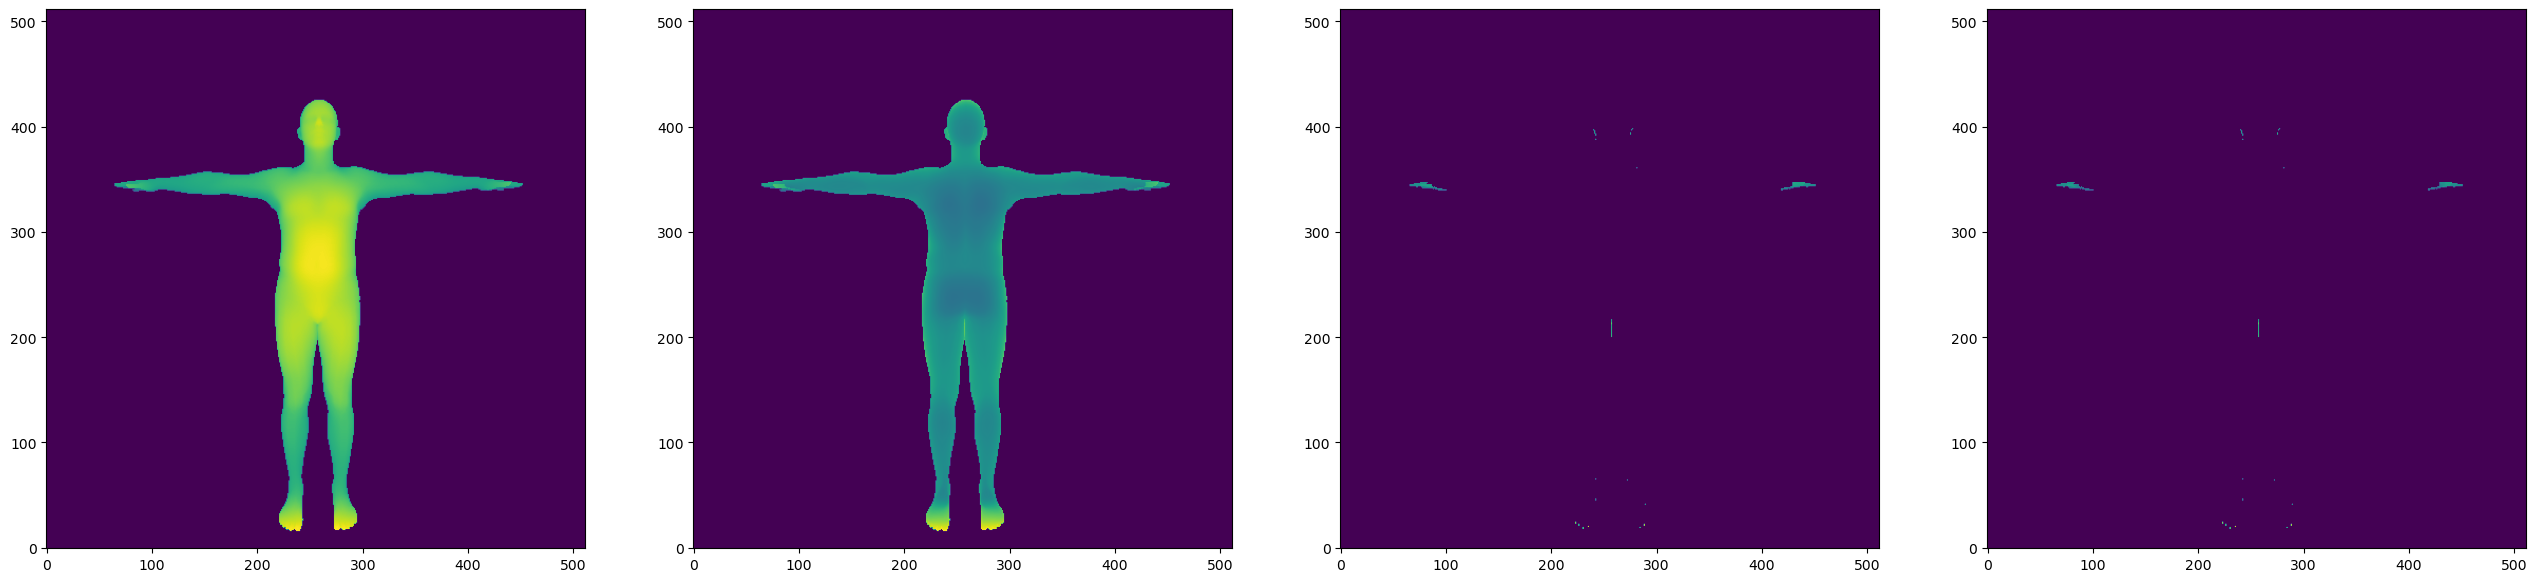

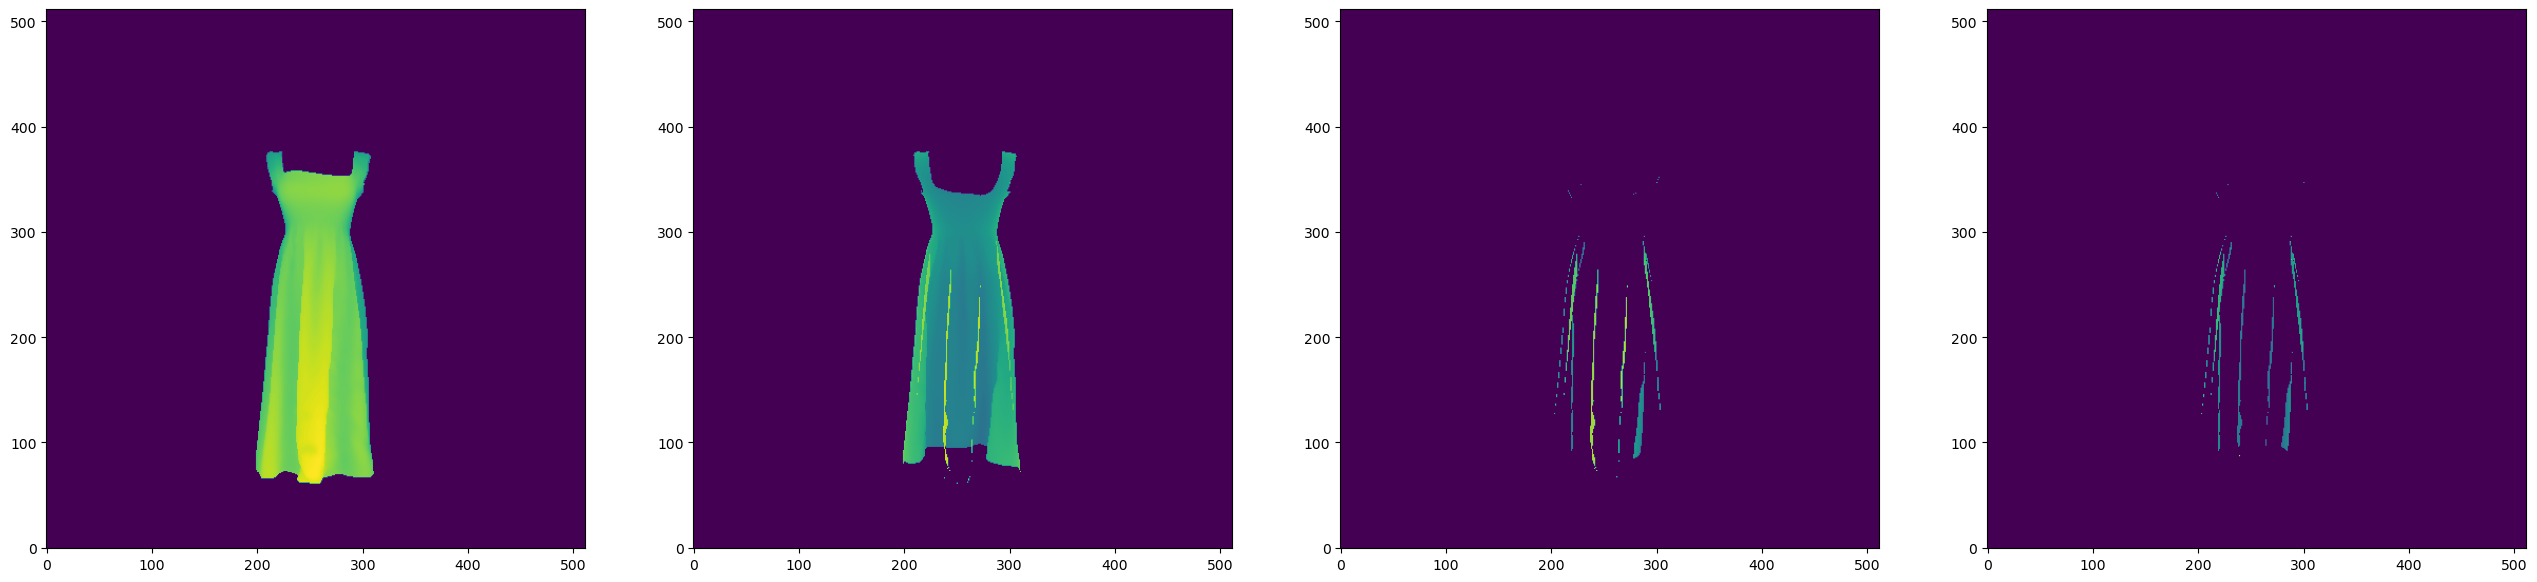

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


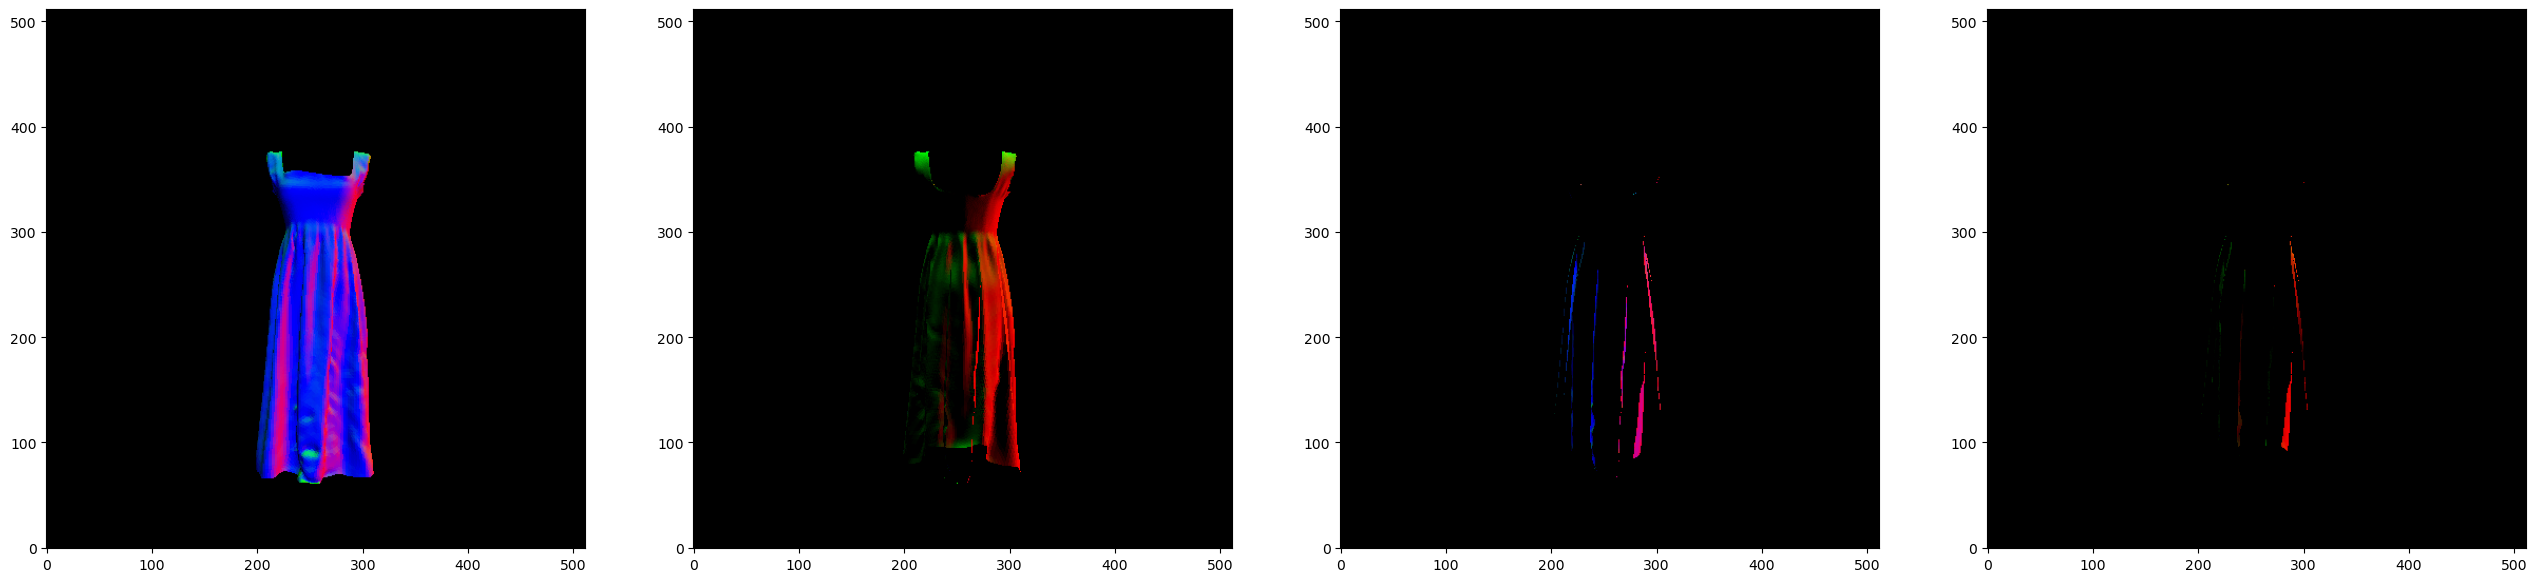

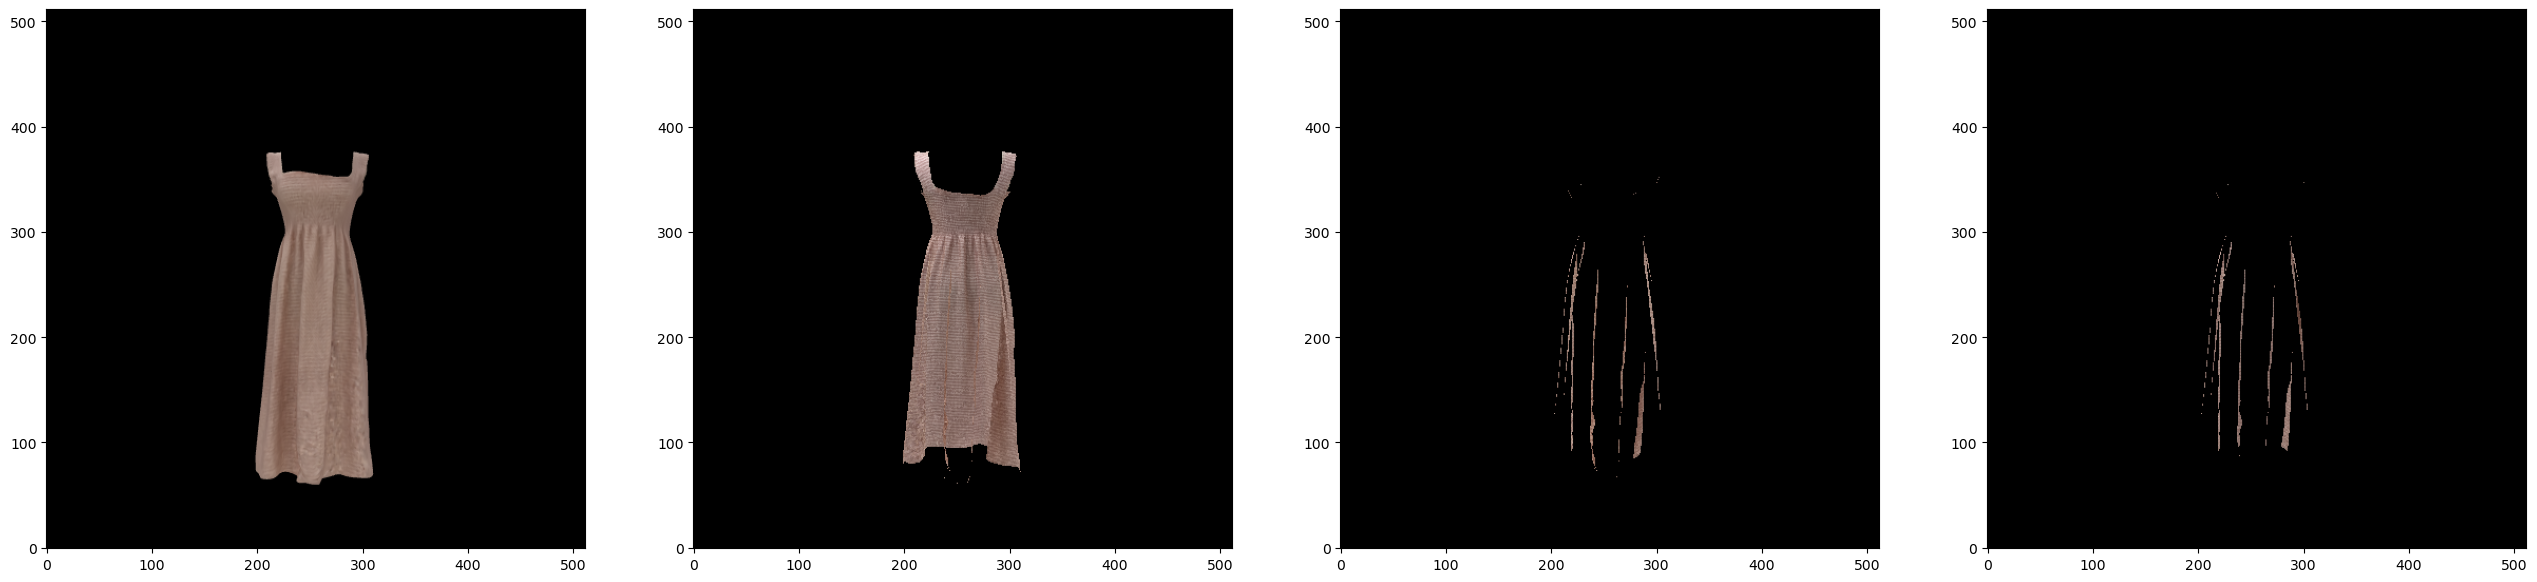

In [90]:
from matplotlib import pyplot as plt
from xcloth.utils import plot_3d, plot_depth

plot_depth(X_train[3:].cpu().numpy())
plot_depth(y_train["Depth"].cpu().numpy().squeeze())
plot_3d(y_train["Norm"].cpu().numpy())
plot_3d(np.concatenate([X_train[:3].unsqueeze(0).cpu().numpy(), y_train["RGB"].cpu().numpy()], axis=0))

In [91]:
from xcloth.components.utils import GarmentModel3D

garment = GarmentModel3D(
    img=X_train[:3].cpu().numpy(),
    pm_depth=y_train["Depth"].cpu().numpy(),
    pm_norm=y_train["Norm"].cpu().numpy(),
    pm_rgb=y_train["RGB"].cpu().numpy(),
).make_rgb()

garment.reconstruct(thres=0, depth_offset=.5)
garment.save_pcd("../no_git_test_data/88-1/reconstructed")

In [111]:
# %%script skipped

from xcloth.train import train_model
from xcloth.production import XCloth

xcloth = XCloth().cuda()
# xcloth(sample_in, sample_smpl)

train_model(
    xcloth,
    dataset,
    verbose=True,
    n_epoch=5,
    reduction="mean",
    weight=[1., 0.1, 1., 0.05, 1, 0.5],
    params_path="../../data/test_data/params.pt",
    separate_bg=True,
)

epoch 1: loss: 2.4107134342193604
epoch 2: loss: 2.0830376148223877
epoch 3: loss: 1.7938339710235596
epoch 4: loss: 1.635344386100769
epoch 5: loss: 1.5441433191299438


In [104]:
from xcloth.production import XCloth

model = XCloth().to(device="cpu")
model.load("../../data/test_data/params.pt")

thres = 0.25

with torch.no_grad():
    r = model(X_train[:3], X_train[3:])

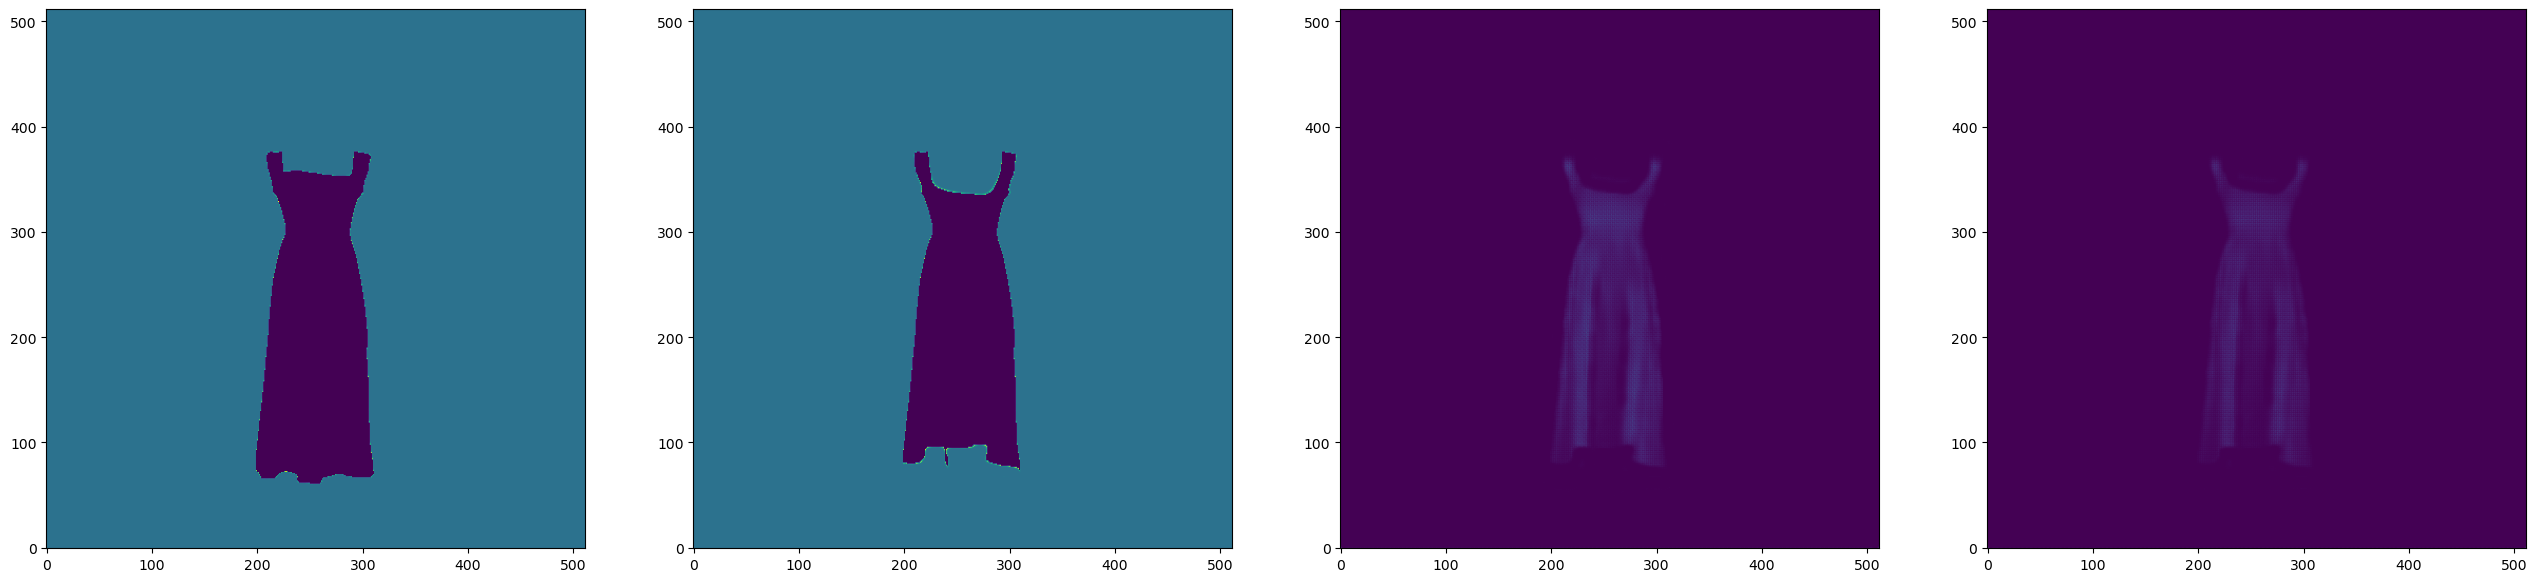

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


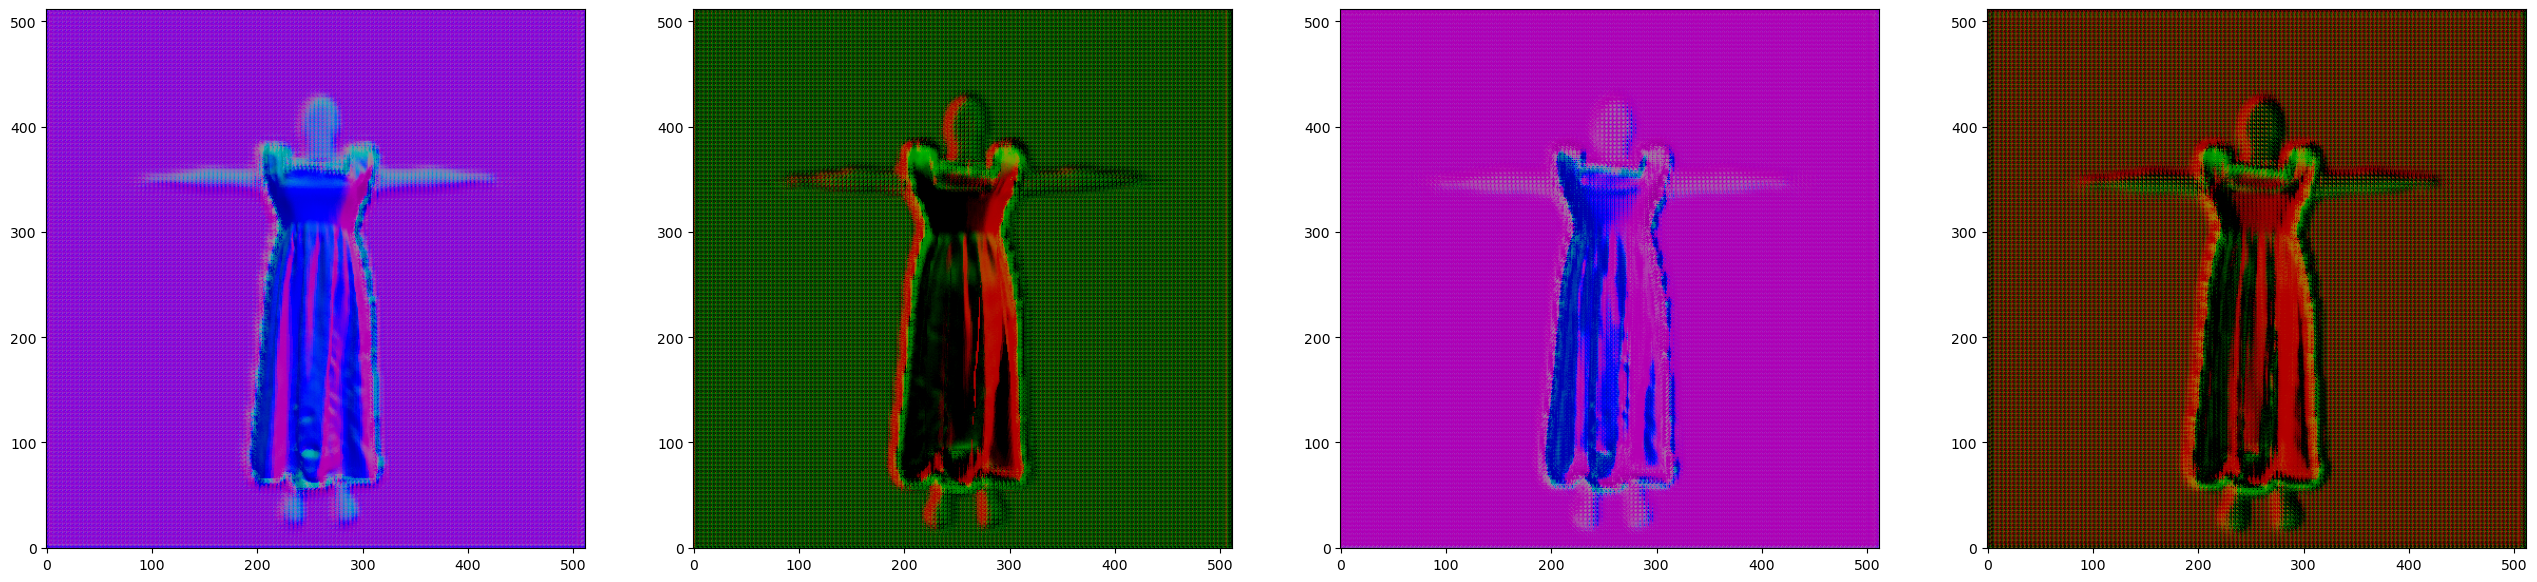

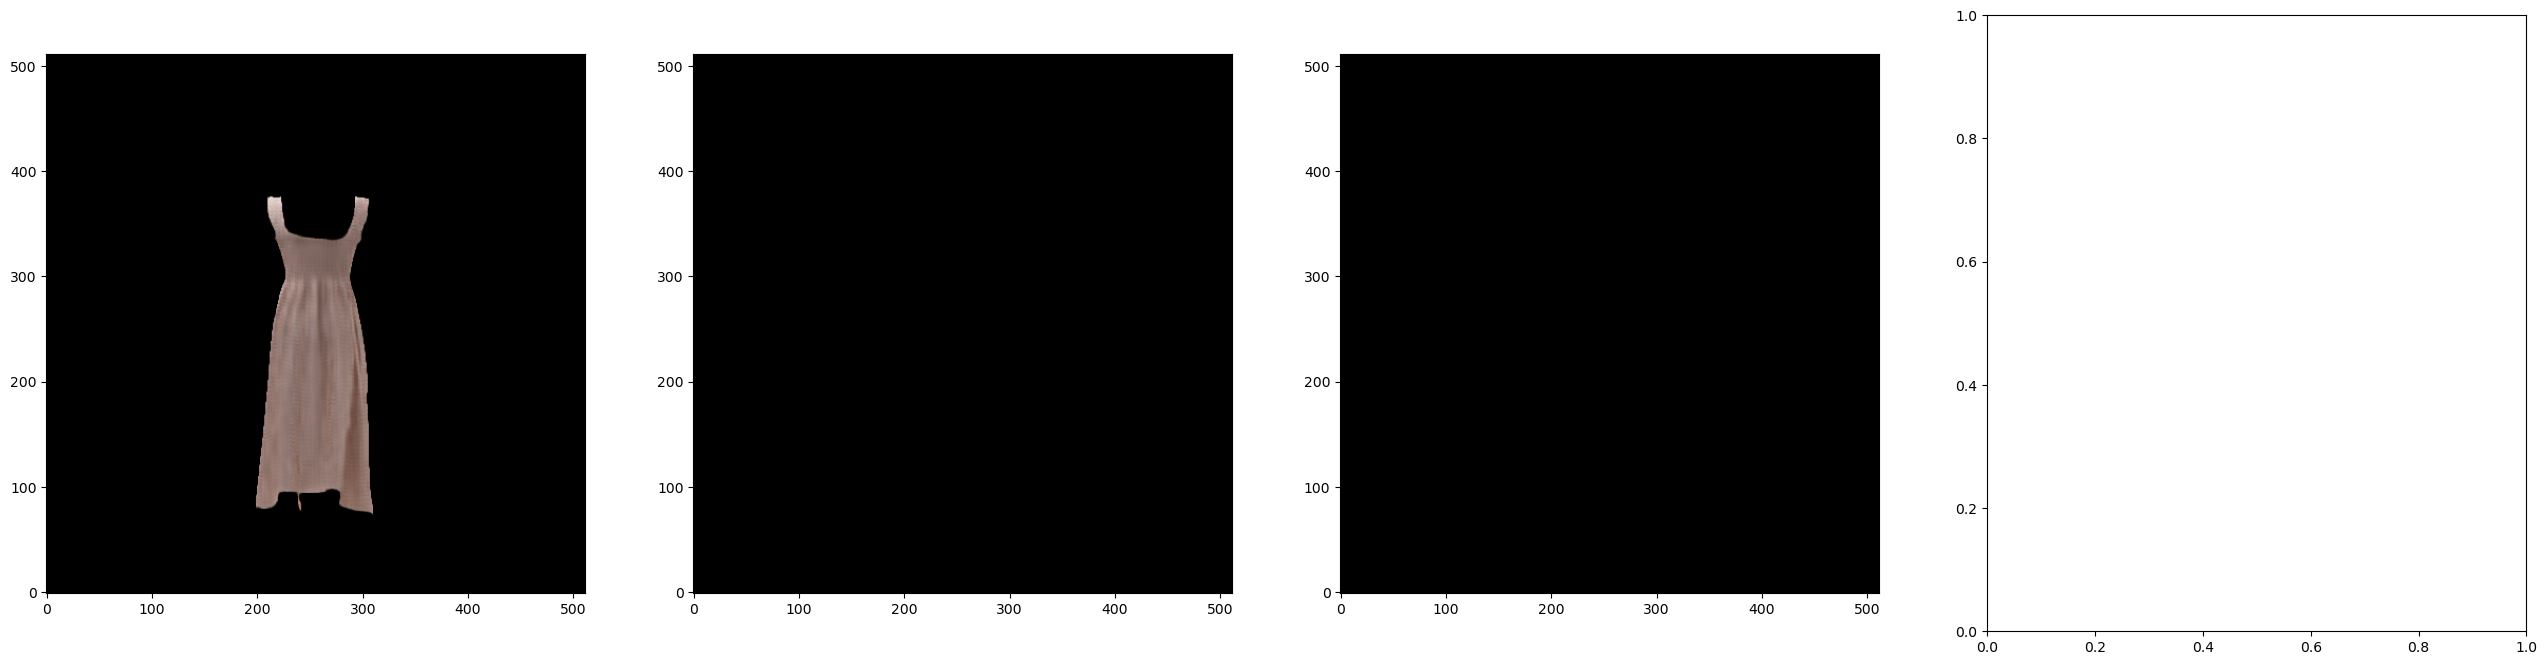

In [105]:
tmp = r["Depth"][0].cpu().detach().numpy().squeeze() - .5
tmp[np.abs(tmp) < thres] = 0
plot_depth(tmp)
plot_3d((r["Norm"][0].cpu().detach().numpy()))
plot_3d((r["RGB"][0].cpu().detach().numpy()))

In [106]:
from xcloth.components.utils import GarmentModel3D
mesh = GarmentModel3D.from_tensor_dict(r, 1)

In [107]:
# mesh[0].mask = y_train["Depth"][0, 0, 0].squeeze().cpu().numpy()
# mesh[0].mask = mesh[0].mask != 0
mesh[0].reconstruct(thres=thres, depth_offset=.5, path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r")

In [108]:
%reload_ext autoreload
%autoreload 2

mesh[0].to_obj(path="C:\\Users\\User\\CODE\\FYP\\models\\xcloth\\no_git_test_data\\pcd\\88-1_r\\reconstructed.obj", mode="poisson", depth=7)

TriangleMesh with 13075 points and 26146 triangles.